# Contando Palavras
Neste capítulo iremos começar a interagir com os textos no nível da linguagem, por meio das ferramentas do Processamento de Linguagem Natural (PLN). Vamos progredir gradualmente nossa representação da linguagem a partir da morfologia, passando pela sintaxe e chegando à semântica. 

Nesta etapa, faremos uso de biliotecas especializadas em PLN como o [NLTK](https://www.nltk.org/) e a [Spacy](https://spacy.io/). 

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import nltk
import spacy
from collections import Counter
import pandas as pd
from sqlalchemy import create_engine
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Bibliotecas de PLN requerem o carregamento de modelos de liguagem para funcionar de maneira apropriada: para este capitulo iremos carregar os modelos específicos da lingua portuguesa. Para isso precisamos executar comandos no terminal do sistema operacional:

In [39]:
# Descomente a linha abaixo para instalar o modelo para a língua portuguesa.
# !python3 -m spacy download pt_core_news_sm

Para contar as palavras de um texto, é preciso primeiro separá-las uma a uma. A este processo dá-se o nome de tokenização, e é típicamente fácil de fazer mal-feito e difícil de fazer bem-feito.

Primeiramente precisaremos carregar os verbetes com a função que criamos no capítulo 1.

In [40]:
import glob, os
caminho = "../dhbb/text/*.text"
arquivos  = glob.glob(caminho)

def tabula_verbete(n=None):
    """
    Carrega todos os verbetes disponíveis, ou os primeiros n.
    n:  número de verbetes a tabular
    """
    if n is None:
        n = len(arquivos)
    linhas = []
    for a in arquivos[:n]:
        with open (a, 'r', encoding='utf8') as f:
            verbete = f.read()
        cabeçalho = verbete.split('---')[1]
        campos = {l.split(':')[0].strip() :l.split(':')[1].strip() for l in cabeçalho.split('\n')[:4] if l}
        campos['arquivo'] = os.path.split(a)[1]
        campos['cargos'] = pd.np.nan if 'cargos:' not in cabeçalho else cabeçalho.split('cargos:')[1]
        campos['corpo'] = verbete.split('---')[2]
        linhas.append(campos)
    tabela = pd.DataFrame(data = linhas, columns=['arquivo','title', 'natureza', 'sexo', 'cargos', 'corpo'])
    return tabela

## Lendo os verbetes do Banco de Dados

In [41]:
tabela = tabula_verbete()

In [42]:
eng = create_engine("sqlite:///minha_tabela.sqlite")
#dhbb = pd.read_sql_table('resultados')
biograficos = pd.read_sql_query('select * from resultados where natureza="biográfico"', con=eng)
biograficos.head()

,index,arquivo,title,natureza,sexo,cargos,corpo
0,1,4361.text,"PRATES, Mílton",biográfico,m,\n - const. 1946\n - dep. fed. MG 1946-1951 \n,\n\n«Luís Mílton Prates» nasceu em Montes Clar...
1,2,5224.text,"SUREK, Alberto",biográfico,m,\n - const. 1934\n - dep. fed. prof. 1935-193...,\n\n«Alberto Surek» nasceu em Araucária (PR) n...
2,3,5039.text,"SILVA, Luís Gonzaga do Nascimento e",biográfico,m,\n - pres. BNH 1965-1966\n - min. Trab. 1966-...,\n\n«Luís Gonzaga do Nascimento e Silva» nasce...
3,5,756.text,"BORJA, Célio",biográfico,m,\n - dep. fed. GB 1971-1975\n - dep. fed. RJ 1...,\n\n«Célio de Oliveira Borja» nasceu no Rio de...
4,6,5352.text,"TORRES, Fontes",biográfico,m,\n - dep. fed. RJ 1964-1967 \n,\n\n«José Fontes Torres» nasceu em Santo Antôn...


## Tokenização com o NLTK

In [43]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/fccoelho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
palavras = nltk.word_tokenize(biograficos.corpo[0])
palavras[:10]

['«', 'Luís', 'Mílton', 'Prates', '»', 'nasceu', 'em', 'Montes', 'Claros', '(']

Uma vez "tokenizado" o texto, podemos contar as palavras muito simplesmente usando a função `Counter`do Python

In [45]:
c = Counter(palavras)
c.most_common(n=10)

[('de', 17),
 ('.', 14),
 (',', 10),
 ('do', 9),
 ('a', 6),
 ('da', 5),
 ('em', 4),
 ('e', 4),
 ('(', 3),
 (')', 3)]

Outra maneira de fazer isso seria usando o NLTK. Com a vantagem de ainda podermos visualizar graficamente.

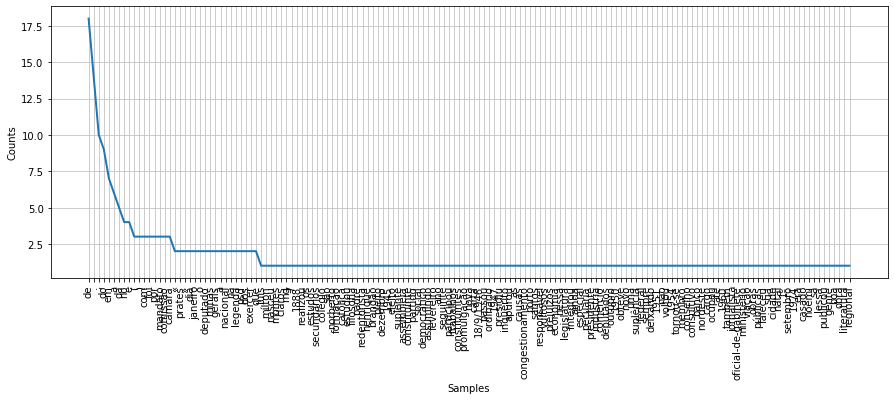

In [46]:
figure(figsize=(15,5))
fd = nltk.FreqDist([p.lower() for p in palavras])
fd.plot();

In [47]:
print("Numero de tokens:", len(palavras))
print("Tamanho do Vocabulário:", len(set([p.lower() for p in palavras])))

Numero de tokens: 252
Tamanho do Vocabulário: 151


Como vemos no exemplo acima, as palavras mais frequentes não muito informativas. Muitas vezes pode ser útil removê-las da análise. Linguistas costumams chamar este tipo de palavras de **stop-words**. Alem disso, vamos tambem remover as pontuaçoes. 

### Removendo as Stopwords

In [48]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fccoelho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Vamos juntas as stopwords e a pontuação em uma única lista:

In [49]:
sw = nltk.corpus.stopwords.words('portuguese')
from string import punctuation
print(punctuation)
sw[:10]

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

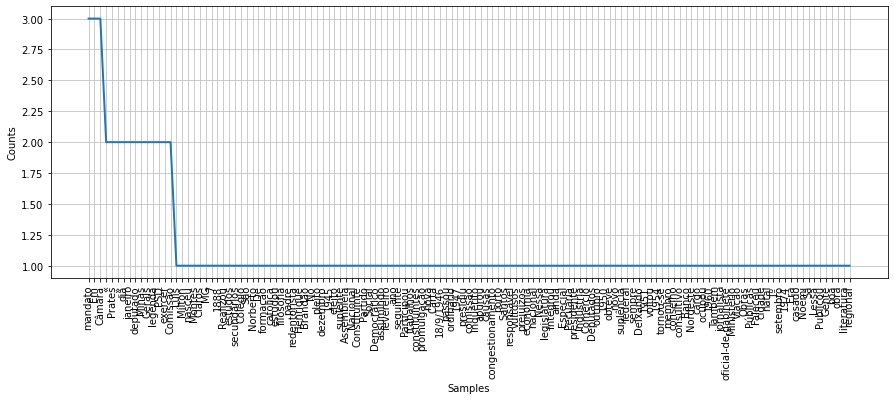

In [50]:
figure(figsize=(15,5))
fd = nltk.FreqDist([p for p in palavras if p not in sw+list(punctuation)])
fd.plot();

# Analizando coleções de textos
Acima analizamos o conteúdo de apenas um verbete, mas seria bem mais relevante podermos fazer a análise em uma coleção de verbetes. Para isso aprenderemos a criar um objeto `TextCollection` que como o nome diz, representa uma coleção de texto, mas que nos permite a realização de análises a nível de coleção.

In [51]:
tc = nltk.TextCollection([nltk.word_tokenize(c) for c in biograficos.corpo])

In [52]:
nltk.FreqDist(tc)

FreqDist({',': 587463, 'de': 517135, '.': 259247, 'do': 226381, 'a': 214979, 'e': 192479, 'da': 181854, 'em': 153158, 'o': 148578, ')': 87927, ...})

In [53]:
tc.concordance('filho', width=150)

Displaying 25 of 10181 matches:
Alberto Surek » nasceu em Araucária ( PR ) no dia 21 de abril de 1899 , filho de Martim Surek e de Maria Surek . Fez os primeiros estudos em sua cida
mento e Silva » nasceu em Itajubá ( MG ) no dia 24 de janeiro de 1915 , filho do advogado Francisco Eulálio do Nascimento e Silva Filho e de Maria do
iro de 1915 , filho do advogado Francisco Eulálio do Nascimento e Silva Filho e de Maria do Rosário Bento do Nascimento e Silva . Em sua família , de
dispendioso instrumento de corrupção e subversão ” , segundo Luís Viana Filho . Nascimento e Silva empenhou-se na reforma e , ainda em novembro de 19
transformando-o em decreto-lei ainda em 1966 . De acordo com Luís Viana Filho , “ entre os trabalhadores a medida produziu bom efeito . Golberi [ do 
nto e Silva , falecida em 1986 , com quem teve um casal de filhos . Seu filho Luís Roberto do Nascimento e Silva foi ministro da Cultura entre 1993 e
 Rio de Janeiro , então Distrito Federal , no dia 15 de julho de 192

In [23]:
linhas = tc.concordance_list('filho',width=150)
linhas[0]

ConcordanceLine(left=['casado', 'com', 'Noemi', 'de', 'Sá', 'Lessa', 'Prates', '.', 'Publicou', '«', 'Gente', 'boa', '»', ',', 'obra', 'de', 'literatura', 'regional', '.', '«', 'Alberto', 'Surek', '»', 'nasceu', 'em', 'Araucária', '(', 'PR', ')', 'no', 'dia', '21', 'de', 'abril', 'de', '1899', ','], query='filho', right=['de', 'Martim', 'Surek', 'e', 'de', 'Maria', 'Surek', '.', 'Fez', 'os', 'primeiros', 'estudos', 'em', 'sua', 'cidade', 'natal', 'e', 'de', '1912', 'a', '1915', 'cursou', 'o', 'Ginásio', 'Diocesano', ',', 'em', 'Curitiba', '.', 'Guarda-livros', 'da', 'firma', 'Magalhães', 'e', 'Companhia', ','], offset=270, left_print='Alberto Surek » nasceu em Araucária ( PR ) no dia 21 de abril de 1899 ,', right_print='de Martim Surek e de Maria Surek . Fez os primeiros estudos em sua cida', line='Alberto Surek » nasceu em Araucária ( PR ) no dia 21 de abril de 1899 , filho de Martim Surek e de Maria Surek . Fez os primeiros estudos em sua cida')

In [54]:
print(*linhas[0].right)

de Martim Surek e de Maria Surek . Fez os primeiros estudos em sua cidade natal e de 1912 a 1915 cursou o Ginásio Diocesano , em Curitiba . Guarda-livros da firma Magalhães e Companhia ,


## Exercício
Utilizando a ferramenta de concordance, procure extrair a filiação dos verbetados, escrevendo uma função que percorra todas as ocorrências da palavra "filho", separando aquelas com sentido de indicação de filiação.

In [55]:
def parse_progenitores(linha):
    '''
    A partir de uma linha do DHBB contendo nomes de pai e mãe, extrai os nomes e os retorna
    '''
    right = linha.right[1:]
    try:
        pos_virg = right.index(',')
    except ValueError:
        pos_virg = 100
    try:
        pos_pt = right.index('.')
    except ValueError:
        pos_pt = 100
    fim = min(pos_virg, pos_pt)
    pais = right[:fim]
    if 'e' in pais:
        pai = " ".join(pais[:pais.index('e')])
        mae = " ".join([p for p in pais[pais.index('e'):] if p not in [',', 'de', 'e']])
    else:
        pai = " ".join(pais)
        mae = "desconhecida."
    return pai, mae

def encontra_pais(tc):
    linhas = tc.concordance_list('filho',width=180, lines=50000) + tc.concordance_list('filha',width=180, lines=50000)
    print("Processando {} linhas".format(len(linhas)))
    i = 0
    for linha in linhas:
        if linha.right[0] not in ['de', 'da', 'do']:
            continue
        pai, mae = parse_progenitores(linha)
        i += 1
        if i <11:
            print("Pai:",pai, '\n', "Mãe:", mae)
    print("Encontramos progenitores em {} linhas".format(i))
encontra_pais(tc)

Processando 11028 linhas
Pai: Martim Surek 
 Mãe: Maria Surek
Pai: advogado Francisco Eulálio do Nascimento 
 Mãe: Silva Filho Maria do Rosário Bento do Nascimento Silva
Pai: Francisco Filinto de Oliveira Borja 
 Mãe: Maria Benjamin Borja
Pai: Francisco C. Torres Sobrinho 
 Mãe: Emiliana Fontes Torres
Pai: médico José Dauster Mota 
 Mãe: Silva Josefa Magalhães Silva
Pai: Augusto Amaral Peixoto 
 Mãe: Alice Monteiro Amaral Peixoto
Pai: Carlos Alberto de Otero 
 Mãe: Maria José Leivas Otero
Pai: Salviano Monteiro Guimarães 
 Mãe: Olívia Campos Guimarães
Pai: Filipe Cossio Pomar 
 Mãe: Rosa Araújo Pomar
Pai: Pedro Pomar 
 Mãe: desconhecida.
Encontramos progenitores em 6459 linhas


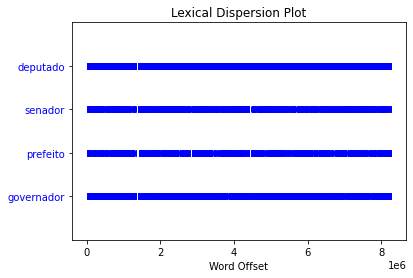

In [56]:
tc.dispersion_plot(['deputado', 'senador', 'prefeito', 'governador'])

# Separando frases
Além de quebrar os textos em seus tokens constituintes, podemos também dividi-los por frases, o que pode ser mais convenientes para certas análises. Para isso utilizamos a função `sent_tokenize` do nltk.

In [57]:
nltk.tokenize.sent_tokenize(biograficos.corpo[0])

['\n\n«Luís Mílton Prates» nasceu em Montes Claros (MG) no dia 7 de janeiro de\n1888.',
 'Realizou os estudos secundários no Colégio São Norberto.',
 'De formação\ncatólica, estudou filosofia com o padre redentorista Henrique Brandão.',
 'No pleito de dezembro de 1945 foi eleito suplente de deputado por Minas\nGerais à Assembléia Nacional Constituinte na legenda do Partido Social\nDemocrático (PSD), assumindo o mandato em fevereiro do ano seguinte.',
 'Participou dos trabalhos constituintes e, com a promulgação da nova\nCarta (18/9/1946), passou a exercer mandato ordinário.',
 'Em 1947 presidiu\na comissão de inquérito da Câmara que apurou as causas do\ncongestionamento do porto de Santos, responsável por vultosos prejuízos\nà economia nacional.',
 'Nessa legislatura integrou ainda a Comissão\nEspecial de Pecuária e foi presidente da Comissão de Indústria e\nComércio da Câmara dos Deputados.',
 'Em outubro de 1950 obteve de novo uma\nsuplência de deputado federal por Minas Gerais, semp

# Busca textual
Realizar uma busca textual em uma coleção de textos é muito mais eficiente do que simplesmente realizar operações sobre coleções de strings. Neste capítulo iremos examinar como "indexar" o DHBB, usando um simples indexador/buscador chamado [whoosh](https://whoosh.readthedocs.io). 

In [28]:
from whoosh import index 
import os
from whoosh.fields import *
from IPython.core.display import display, HTML

In [29]:
schema = Schema(title=TEXT(stored=True), sexo=ID(stored=True), caminho=ID(stored=True), corpo=TEXT(stored=True))

In [30]:
if not os.path.exists('indexdir'):
    os.mkdir('indexdir')
    ix = index.create_in("indexdir", schema)
else:
    # ix = index.open_dir('indexdir') # se quiser adicionar novos documentos ao índice
    ix = index.create_in("indexdir", schema) # se Quiser começar do zero

In [31]:
writer = ix.writer()

In [32]:
for v in biograficos.itertuples():
    if pd.isnull(v.sexo):
        writer.add_document(title=v.title,sexo='na', caminho=v.arquivo,corpo=v.corpo)
    else:
        writer.add_document(title=v.title,sexo=v.sexo, caminho=v.arquivo,corpo=v.corpo)
writer.commit()

In [33]:
from whoosh.qparser import QueryParser
from whoosh import qparser

In [34]:
def busca(consulta):
    qp = QueryParser("corpo", ix.schema)
    qp.add_plugin(qparser.EveryPlugin())
    query = qp.parse(consulta)
    
    with ix.searcher() as searcher:
        results = [(dict(hit),hit.highlights("corpo")) for hit in searcher.search(query, limit=10)]
    return results
    

In [35]:
resultados = busca('assassin*')


In [36]:
print('Resultados:', len(resultados))
for res in resultados[:10]:
    print(res[0]['title'])
    display(HTML(res[1]))
   # encontra_pais(nltk.Text(nltk.tokenize.wordpunct_tokenize(res[0]['corpo'])))

Resultados: 10
PASCOAL, Hildebrando


PASCOAL, Hildebrando


RIPPOL, Valdemar


RIPPOL, Valdemar


CUNHA, Francisco Flores da


CUNHA, Francisco Flores da


MENDES, Chico


MENDES, Chico


CUNHA NETO, Augusto


CUNHA NETO, Augusto
